In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\naqsh\.conda\envs\dl_env\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
meta_data_path = r'C:\Users\naqsh\OneDrive\Desktop\Projects\Roadside-sign-recognition\data\Meta.csv'
meta_df = pd.read_csv(meta_data_path)

train_data_path = r'C:\Users\naqsh\OneDrive\Desktop\Projects\Roadside-sign-recognition\data\Train.csv'
train_df = pd.read_csv(train_data_path)

test_data_path = r'C:\Users\naqsh\OneDrive\Desktop\Projects\Roadside-sign-recognition\data\Test.csv'
test_df = pd.read_csv(test_data_path)


print("Meta Data:")
print(meta_df.head())
print("\nTraining Data:")
print(train_df.head())

Meta Data:
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22

Training Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [3]:
print(meta_df.columns)
sign_names = meta_df.set_index('ClassId')['SignId'].to_dict() 


Index(['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId'], dtype='object')


Total number of unique classes:  43


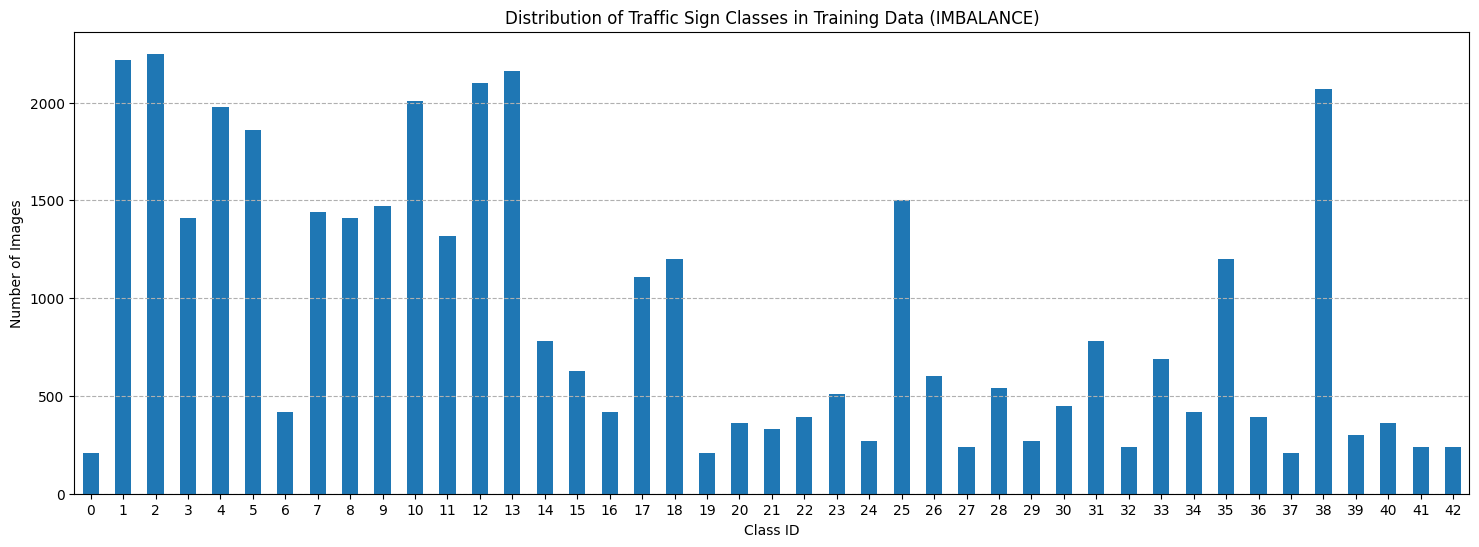

Smallest class count: 210
Largest class count: 2250


In [4]:
class_counts = train_df['ClassId'].value_counts().sort_index()
num_classes = len(class_counts)

print("Total number of unique classes: ",num_classes)

plt.figure(figsize=(18, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Traffic Sign Classes in Training Data (IMBALANCE)')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

print(f"Smallest class count: {class_counts.min()}")
print(f"Largest class count: {class_counts.max()}")

In [5]:

import os
base_data_path = 'C:/Users/naqsh/OneDrive/Desktop/Projects/Roadside-sign-recognition/data/'

train_df['Path'] = train_df['Path'].apply(lambda x: os.path.join(base_data_path, x).replace('\\', '/'))

test_folder_path = os.path.join(base_data_path, 'Test')

test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(test_folder_path, x).replace('\\', '/'))

# num_classes = len(train_df['ClassId'].unique()) 

print("✅ DataFrames updated with absolute paths.")

✅ DataFrames updated with absolute paths.


In [19]:


IMG_SIZE = 48 

X_train_raw = []
y_train_raw = []

print("⏳ Starting image loading and preprocessing for training data...")

path_column = 'Path'

for index, row in train_df.iterrows():
    image_path = row[path_column]
    
    img = Image.open(image_path)
    
    img = img.resize((IMG_SIZE, IMG_SIZE))
    
    X_train_raw.append(np.array(img))
    y_train_raw.append(row['ClassId'])

X_train_raw = np.array(X_train_raw)
y_train_raw = np.array(y_train_raw)

X_train_raw = X_train_raw / 255.0
y_train_raw = to_categorical(y_train_raw, num_classes=num_classes)

print("✅ Training data loading complete.")
print(f"Raw Training data shape: {X_train_raw.shape}, Raw Labels shape: {y_train_raw.shape}")


X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train_raw, test_size=0.2, random_state=42, stratify=y_train_raw.argmax(axis=1)
)

print("\n--- Final Data Shapes ---")
print(f"Training data shape (X_train): {X_train.shape}, Labels shape (y_train): {y_train.shape}")
print(f"Validation data shape (X_val): {X_val.shape}, Labels shape (y_val): {y_val.shape}")

⏳ Starting image loading and preprocessing for training data...
✅ Training data loading complete.
Raw Training data shape: (39209, 48, 48, 3), Raw Labels shape: (39209, 43)

--- Final Data Shapes ---
Training data shape (X_train): (31367, 48, 48, 3), Labels shape (y_train): (31367, 43)
Validation data shape (X_val): (7842, 48, 48, 3), Labels shape (y_val): (7842, 43)


In [20]:
# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=10,         
    zoom_range=0.15,          
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    shear_range=0.1,          
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'      
)
datagen.fit(X_train)

print("✅ Data Augmentation Generator configured.")

✅ Data Augmentation Generator configured.


In [21]:
#  Building the CNN Model Architecture

def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    # model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

input_shape = X_train.shape[1:] 
model = build_cnn_model(input_shape, num_classes)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

c:\Users\naqsh\.conda\envs\dl_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 44, 44, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,371 (4.36 MB)

 Trainable params: 1,143,371 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

from sklearn.utils import class_weight
import numpy as np

y_integers = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weight_dict = dict(enumerate(class_weights))

print("✅ Class Weight Dictionary created (ClassId: Weight):")
print({k: round(v, 2) for k, v in class_weight_dict.items()})



✅ Class Weight Dictionary created (ClassId: Weight):
{0: np.float64(4.34), 1: np.float64(0.41), 2: np.float64(0.41), 3: np.float64(0.65), 4: np.float64(0.46), 5: np.float64(0.49), 6: np.float64(2.17), 7: np.float64(0.63), 8: np.float64(0.65), 9: np.float64(0.62), 10: np.float64(0.45), 11: np.float64(0.69), 12: np.float64(0.43), 13: np.float64(0.42), 14: np.float64(1.17), 15: np.float64(1.45), 16: np.float64(2.17), 17: np.float64(0.82), 18: np.float64(0.76), 19: np.float64(4.34), 20: np.float64(2.53), 21: np.float64(2.76), 22: np.float64(2.34), 23: np.float64(1.79), 24: np.float64(3.38), 25: np.float64(0.61), 26: np.float64(1.52), 27: np.float64(3.8), 28: np.float64(1.69), 29: np.float64(3.38), 30: np.float64(2.03), 31: np.float64(1.17), 32: np.float64(3.8), 33: np.float64(1.32), 34: np.float64(2.17), 35: np.float64(0.76), 36: np.float64(2.34), 37: np.float64(4.34), 38: np.float64(0.44), 39: np.float64(3.04), 40: np.float64(2.53), 41: np.float64(3.8), 42: np.float64(3.8)}


In [22]:

EPOCHS = 25
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

model.save('road_sign_classifier_gtsrb.h5')
print("✅ Model training complete and model saved.")

Epoch 1/25
161/491 ━━━━━━━━━━━━━━━━━━━━ 1:27 264ms/step - accuracy: 0.0534 - loss: 3.5924

KeyboardInterrupt: 

In [19]:


X_test = []
y_test = []

print("⏳ Starting image loading and preprocessing for TEST data...")

test_path_column = 'Path' 

for index, row in test_df.iterrows():
    image_path = row[test_path_column]
    
    img = Image.open(image_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    
    X_test.append(np.array(img))
    y_test.append(row['ClassId'])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test / 255.0
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"✅ Test data loading complete. Shape: {X_test.shape}")



y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = np.argmax(y_test, axis=1)       

print("\n--- Classification Report (Precision, Recall, F1-Score) ---")
print(classification_report(y_true, y_pred, target_names=[sign_names[i] for i in range(num_classes)], digits=4))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, rotation=90)
plt.yticks(tick_marks)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

⏳ Starting image loading and preprocessing for TEST data...
✅ Test data loading complete. Shape: (12630, 32, 32, 3)
395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step

--- Classification Report (Precision, Recall, F1-Score) ---


c:\Users\naqsh\.conda\envs\dl_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


TypeError: object of type 'float' has no len()

In [7]:

from sklearn.utils import class_weight
import numpy as np

y_integers = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weight_dict = dict(enumerate(class_weights))

print("✅ Class Weight Dictionary created (ClassId: Weight):")
print({k: round(v, 2) for k, v in class_weight_dict.items()})



✅ Class Weight Dictionary created (ClassId: Weight):
{0: np.float64(4.34), 1: np.float64(0.41), 2: np.float64(0.41), 3: np.float64(0.65), 4: np.float64(0.46), 5: np.float64(0.49), 6: np.float64(2.17), 7: np.float64(0.63), 8: np.float64(0.65), 9: np.float64(0.62), 10: np.float64(0.45), 11: np.float64(0.69), 12: np.float64(0.43), 13: np.float64(0.42), 14: np.float64(1.17), 15: np.float64(1.45), 16: np.float64(2.17), 17: np.float64(0.82), 18: np.float64(0.76), 19: np.float64(4.34), 20: np.float64(2.53), 21: np.float64(2.76), 22: np.float64(2.34), 23: np.float64(1.79), 24: np.float64(3.38), 25: np.float64(0.61), 26: np.float64(1.52), 27: np.float64(3.8), 28: np.float64(1.69), 29: np.float64(3.38), 30: np.float64(2.03), 31: np.float64(1.17), 32: np.float64(3.8), 33: np.float64(1.32), 34: np.float64(2.17), 35: np.float64(0.76), 36: np.float64(2.34), 37: np.float64(4.34), 38: np.float64(0.44), 39: np.float64(3.04), 40: np.float64(2.53), 41: np.float64(3.8), 42: np.float64(3.8)}


In [8]:

def build_cnn_model(input_shape, num_classes):
    model2 = Sequential()
    
    # added Padding = "same"
    model2.add(Conv2D(64, (5, 5),padding = "same", activation='relu', input_shape=input_shape))
    model2.add(BatchNormalization())
    model2.add(Conv2D(64, (5, 5),padding="same", activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.15)) # Reduced Dropout

    model2.add(Conv2D(128, (3, 3), padding = "same", activation='relu')) # Increased filters
    model2.add(BatchNormalization())
    model2.add(Conv2D(128, (3, 3),padding="same", activation='relu')) # Increased filters
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.15)) # Reduced Dropout

    model2.add(Flatten())
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.3)) # Reduced Dropout
    
    model2.add(Dense(num_classes, activation='softmax'))
    
    return model2

input_shape = X_train.shape[1:] 
model2 = build_cnn_model(input_shape, num_classes)

model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model2.summary()

c:\Users\naqsh\.conda\envs\dl_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,059,435 (19.30 MB)

 Trainable params: 5,059,051 (19.30 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,          
    patience=3,          
    verbose=1,
    min_lr=1e-6
)

In [10]:
# Data Augmentation

datagen2 = ImageDataGenerator(
    rotation_range=10,         
    zoom_range=0.15,          
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    shear_range=0.1,          
    brightness_range=[0.3, 1.7],
    fill_mode='nearest'      
)
datagen2.fit(X_train)

print("✅ Data Augmentation Generator configured.")

✅ Data Augmentation Generator configured.


In [11]:

EPOCHS = 25
BATCH_SIZE = 32


history2 = model2.fit(
    datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

model2.save('road_sign_classifier_updated.h5')
print("✅ Model training complete and model2 saved.")

Epoch 1/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 1388s 1s/step - accuracy: 0.0304 - loss: 3.8311 - val_accuracy: 0.0340 - val_loss: 3.7532 - learning_rate: 0.0010
Epoch 2/25
 30/981 ━━━━━━━━━━━━━━━━━━━━ 9:01 569ms/step - accuracy: 0.0237 - loss: 3.7024

KeyboardInterrupt: 

In [ ]:
best_model = model2  # use the model already trained
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\n✔ Improved Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\n✔ Precision, Recall, F1:\n")
print(classification_report(y_true, y_pred_classes))